# Orbital Docking Trajectory Optimization
## Bezier Curve-based Path Optimization for ISS Approach

Following Project_Spec.md:
- ISS orbit altitude = 423km AMSL
- Chaser altitude = 300km AMSL  
- KOZ = 100km AMSL (Keep Out Zone)
- Use De Casteljau segmentation
- Linearize KOZ with half-space constraints
- Boundary conditions: position, velocity, acceleration
- Cost: geometric acc - gravitational acc
- Optimizer: SciPy trust-constr

In [ ]:
# Imports and Constants
import numpy as np
from scipy.special import comb
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Enable interactive plots in Jupyter notebook
%matplotlib widget
# Alternative if widget doesn't work: %matplotlib notebook

# Orbital parameters (from Project_Spec.md)
ISS_ALTITUDE_KM = 423  # ISS orbit altitude in km AMSL
CHASER_ALTITUDE_KM = 300  # Chaser altitude in km AMSL
KOZ_ALTITUDE_KM = 100  # Keep Out Zone altitude in km AMSL

EARTH_RADIUS_KM = 6371.0  # Earth radius in km
KOZ_RADIUS = EARTH_RADIUS_KM + KOZ_ALTITUDE_KM  # KOZ radius from Earth center
ISS_RADIUS = EARTH_RADIUS_KM + ISS_ALTITUDE_KM
CHASER_RADIUS = EARTH_RADIUS_KM + CHASER_ALTITUDE_KM

# Gravitational parameters
EARTH_MU = 3.986004418e14  # m³/s²

# Scaling: use km as base unit
SCALE_FACTOR = 1e3  # 1 unit = 1 km
EARTH_MU_SCALED = EARTH_MU / (SCALE_FACTOR**3)  # Scaled for km

print("Constants initialized:")
print(f"  ISS altitude: {ISS_ALTITUDE_KM} km")
print(f"  Chaser altitude: {CHASER_ALTITUDE_KM} km")
print(f"  KOZ radius: {KOZ_RADIUS:.1f} km")


Constants initialized:
  ISS altitude: 423 km
  Chaser altitude: 300 km
  KOZ radius: 6471.0 km


## 1. D and E Matrices Implementation

From Project_Spec.md:
- Velocity: V = EDP
- Acceleration: A = EDEDP
- D: derivative matrix (reduces order by 1)
- E: elevation matrix (increases order by 1)

In [36]:
def get_D_matrix(N):
    """
    Compute derivative matrix D for Bézier curve of degree N.
    
    From Project_Spec.md:
    [D]_i,j = N × { -1 if j=i, 1 if j=i+1, 0 otherwise }
    
    Args:
        N: Degree of Bézier curve
    
    Returns:
        D: (N, N+1) matrix
    """
    D = np.zeros((N, N+1))
    for i in range(N):
        D[i, i] = -N
        D[i, i+1] = N
    return D

def get_E_matrix(N):
    """
    Compute elevation matrix E for Bézier curve of degree N.
    Elevates degree from N to N+1.
    
    From Project_Spec.md equation:
    E_{N→N+1} with specific structure
    
    Args:
        N: Original degree
    
    Returns:
        E: (N+2, N+1) matrix
    """
    E = np.zeros((N+2, N+1))
    
    # First row: i=1, j=1 → 1
    E[0, 0] = 1.0
    
    # Last row: i=N+2, j=N+1 → 1
    E[N+1, N] = 1.0
    
    # Middle rows: 2 ≤ i ≤ N+1 (1-indexed) → rows 1 to N (0-indexed)
    for row_idx in range(1, N+1):  # 0-indexed row: 1 to N
        i_1idx = row_idx + 1  # Convert to 1-indexed for formula
        # j = i-1 (1-indexed) → col = row_idx - 1 (0-indexed)
        E[row_idx, row_idx - 1] = (N + 2 - i_1idx) / (N + 1)
        # j = i (1-indexed) → col = row_idx (0-indexed)
        E[row_idx, row_idx] = (i_1idx - 1) / (N + 1)
    
    return E

# Test matrices for degree 2 (quadratic) and degree 3
print("="*60)
print("Testing D and E matrices")
print("="*60)

# Test D matrix for N=2 (quadratic: 3 control points → 2 control points)
print("\n1. D matrix for N=2 (degree 2, 3→2 control points):")
D2 = get_D_matrix(2)
print(f"D2 (2×3):\n{D2}")
print("Expected pattern: [-N, N, 0] on each row")
print(f"Values: -2 and 2 (correct for N=2)")

# Test D matrix for N=3 (cubic: 4 control points → 3 control points)
print("\n2. D matrix for N=3 (degree 3, 4→3 control points):")
D3 = get_D_matrix(3)
print(f"D3 (3×4):\n{D3}")
print("Expected from spec D3→2 (unscaled pattern):")
print("[[-1, 1, 0, 0],")
print(" [0, -1, 1, 0],")
print(" [0, 0, -1, 1]]")
print(f"Scaled by N=3: multiply by 3")
D3_expected = np.array([[-3, 3, 0, 0], [0, -3, 3, 0], [0, 0, -3, 3]])
print(f"Match: {np.allclose(D3, D3_expected)}")

# Test E matrix for N=2 (elevates from degree 2 to 3)
print("\n3. E matrix for N=2 (elevates degree 2→3, 3→4 control points):")
E2 = get_E_matrix(2)
print(f"E2 (4×3):\n{E2}")
print("\nExpected E2→3 from spec:")
E2_expected = np.array([[1, 0, 0], [2/3, 1/3, 0], [0, 1/3, 2/3], [0, 0, 1]])
print(E2_expected)
print(f"\n✓ Match: {np.allclose(E2, E2_expected)}")

# Test E matrix for N=3 (elevates from degree 3 to 4)
print("\n4. E matrix for N=3 (elevates degree 3→4, 4→5 control points):")
E3 = get_E_matrix(3)
print(f"E3 (5×4):\n{E3}")
print("\nExpected pattern for N=3:")
print("Row 0: [1,   0,   0,   0]")
print("Row 1: [3/4, 1/4, 0,   0]")
print("Row 2: [0,   2/4, 2/4, 0]")
print("Row 3: [0,   0,   1/4, 3/4]")
print("Row 4: [0,   0,   0,   1]")
E3_expected = np.array([
    [1, 0, 0, 0],
    [3/4, 1/4, 0, 0],
    [0, 2/4, 2/4, 0],
    [0, 0, 1/4, 3/4],
    [0, 0, 0, 1]
])
print(f"✓ Match: {np.allclose(E3, E3_expected)}")


Testing D and E matrices

1. D matrix for N=2 (degree 2, 3→2 control points):
D2 (2×3):
[[-2.  2.  0.]
 [ 0. -2.  2.]]
Expected pattern: [-N, N, 0] on each row
Values: -2 and 2 (correct for N=2)

2. D matrix for N=3 (degree 3, 4→3 control points):
D3 (3×4):
[[-3.  3.  0.  0.]
 [ 0. -3.  3.  0.]
 [ 0.  0. -3.  3.]]
Expected from spec D3→2 (unscaled pattern):
[[-1, 1, 0, 0],
 [0, -1, 1, 0],
 [0, 0, -1, 1]]
Scaled by N=3: multiply by 3
Match: True

3. E matrix for N=2 (elevates degree 2→3, 3→4 control points):
E2 (4×3):
[[1.         0.         0.        ]
 [0.66666667 0.33333333 0.        ]
 [0.         0.33333333 0.66666667]
 [0.         0.         1.        ]]

Expected E2→3 from spec:
[[1.         0.         0.        ]
 [0.66666667 0.33333333 0.        ]
 [0.         0.33333333 0.66666667]
 [0.         0.         1.        ]]

✓ Match: True

4. E matrix for N=3 (elevates degree 3→4, 4→5 control points):
E3 (5×4):
[[1.   0.   0.   0.  ]
 [0.75 0.25 0.   0.  ]
 [0.   0.5  0.5  0.  ]
 [0

## 2. BezierCurve Class with D/E Matrix Operations

In [37]:
class BezierCurve:
    """
    Bézier curve implementation using D/E matrices for derivatives.
    """
    
    def __init__(self, control_points):
        P = np.array(control_points, dtype=float)
        if P.ndim != 2: # cus np.array makes control_points a 2D matrix
            raise ValueError("control_points must be (N+1, dim)")
        self.control_points = P
        self.degree = P.shape[0] - 1 # = N
        self.dimension = P.shape[1] # P.shape = (N+1, dim)
        
        # Precompute D and E matrices
        self.D = get_D_matrix(self.degree)
        if self.degree > 0:
            self.E = get_E_matrix(self.degree - 1)  # E elevates from N-1 to N
    
    def point(self, tau):
        """Evaluate curve at parameter tau using Bernstein basis."""
        N, d = self.degree, self.dimension
        out = np.zeros(d)
        for i in range(N + 1):
            b = comb(N, i) * (tau ** i) * ((1 - tau) ** (N - i))
            out += b * self.control_points[i]
        return out
    
    def velocity_control_points(self):
        """
        Compute velocity control points using V = EDP.
        Returns control points for velocity curve (degree N, N+1 control points).
        """
        if self.degree == 0:
            return np.zeros((1, self.dimension))
        
        # V = E @ D @ P
        # P is (N+1, dim), D is (N, N+1), E is (N+1, N)
        # Result: (N+1, dim)
        V_ctrl = self.E @ self.D @ self.control_points
        return V_ctrl
    
    def acceleration_control_points(self):
        """
        Compute acceleration control points using A = EDEDP.
        Returns control points for acceleration curve.
        """
        if self.degree < 2:
            return np.zeros((max(1, self.degree), self.dimension))
        
        # Acceleration control points using EDEDP as instructed.
        if self.degree < 2:
            return np.zeros((max(1, self.degree-1), self.dimension))
        # Use EDEDP directly per the analytic/formal instructions.
        A_ctrl = self.E @ self.D @ self.E @ self.D @ self.control_points
        # (Resulting shape: (N+1, d); may want/truncate to (N-1, d) if only first N-1 segments needed for quadratic basis)
        return A_ctrl
    
    def velocity(self, tau):
        """Evaluate velocity at parameter tau."""
        if self.degree == 0:
            return np.zeros(self.dimension)
        V_ctrl = self.velocity_control_points()
        # Velocity curve has degree N (same as original)
        N = self.degree
        out = np.zeros(self.dimension)
        for i in range(N + 1):
            b = comb(N, i) * (tau ** i) * ((1 - tau) ** (N - i))
            out += b * V_ctrl[i]
        return out
    
    def acceleration(self, tau):
        """Evaluate acceleration at parameter tau."""
        if self.degree < 2:
            return np.zeros(self.dimension)
        A_ctrl = self.acceleration_control_points()
        # Acceleration curve has degree N-2
        N_accel = self.degree - 2
        out = np.zeros(self.dimension)
        for i in range(N_accel + 1):
            b = comb(N_accel, i) * (tau ** i) * ((1 - tau) ** (N_accel - i))
            out += b * A_ctrl[i]
        return out

# Test
P_test = np.array([[0, 0, 0], [1, 1, 0], [2, 0, 0]])  # Quadratic
curve = BezierCurve(P_test)
print(f"Test curve degree: {curve.degree}")
print(f"Velocity at τ=0: {curve.velocity(0)}")
print(f"Acceleration at τ=0: {curve.acceleration(0)}")


Test curve degree: 2
Velocity at τ=0: [2. 2. 0.]
Acceleration at τ=0: [ 0. -4.  0.]



## 3. De Casteljau Segmentation

In [38]:
def de_casteljau_split_1d(N, tau, basis_index):
    """
    Compute De Casteljau subdivision coefficients for a single basis vector.
    """
    w = np.zeros(N+1)
    w[basis_index] = 1.0
    left = [w[0]]
    right = [w[-1]]
    W = w.copy()
    
    for _ in range(1, N+1):
        W = (1 - tau) * W[:-1] + tau * W[1:]
        left.append(W[0])
        right.append(W[-1])
    
    L = np.array(left)
    R = np.array(right[::-1])
    return L, R

def de_casteljau_split_matrices(N, tau):
    """Compute subdivision matrices S_left and S_right."""
    S_left = np.zeros((N+1, N+1))
    S_right = np.zeros((N+1, N+1))
    
    for j in range(N+1):
        L, R = de_casteljau_split_1d(N, tau, j)
        S_left[:, j] = L
        S_right[:, j] = R
    return S_left, S_right

def segment_matrices_equal_params(N, n_seg):
    """
    Generate segment matrices for equal-parameter splitting.
    Returns list of (N+1, N+1) matrices, one per segment.
    """
    if n_seg < 1:
        raise ValueError("n_seg must be >= 1")
    if n_seg == 1:
        return [np.eye(N+1)]
    
    mats = []
    remainder = np.eye(N+1)
    
    for k in range(n_seg, 1, -1):
        tau = 1.0 / k
        S_L, S_R = de_casteljau_split_matrices(N, tau)
        mats.append(S_L @ remainder)
        remainder = S_R @ remainder
    mats.append(remainder)
    return mats

# Test
print("Testing segmentation for N=2, n_seg=4:")
mats = segment_matrices_equal_params(2, 4)
print(f"Number of segments: {len(mats)}")
for i, A in enumerate(mats):
    print(f"Segment {i+1} matrix shape: {A.shape}")


Testing segmentation for N=2, n_seg=4:
Number of segments: 4
Segment 1 matrix shape: (3, 3)
Segment 2 matrix shape: (3, 3)
Segment 3 matrix shape: (3, 3)
Segment 4 matrix shape: (3, 3)


## 4. KOZ Linearization with Half-Space Constraints

From Project_Spec.md:
- For each segment j: calc CG of control points
- Generate unit vector Nj from center of KOZ to CG
- Generate supporting half-space with unit vector Nj
- This linearizes KOZ to inequality constraints

In [ ]:
def build_koz_constraints(A_list, P, r_e, dim=3, c_KOZ=None):
    """
    Build KOZ (Keep Out Zone) linear constraints for all segments.

    For each segment j:
    1. Compute CG (centroid) of control points: Qi = Ai @ P
    2. Generate unit vector nj from KOZ center (c_KOZ) to CG
    3. Create half-space constraint: nj^T @ Qi >= r_e

    Args:
        A_list: List of segment transformation matrices
        P: Control points (N+1, dim)
        r_e: KOZ radius
        dim: Spatial dimension
        c_KOZ: KOZ center, shape (dim,) or None (if None, uses origin and warns)

    Returns:
        LinearConstraint object
    """
    Np1 = A_list[0].shape[1]
    rows, lbs = [], []

    if c_KOZ is None:
        import warnings
        warnings.warn("c_KOZ (KOZ center) not specified; defaulting to origin.")
        c_KOZ = np.zeros(dim)

    for Ai in A_list:
        Qi = Ai @ P  # Control points of segment i
        ci = Qi.mean(axis=0)  # Centroid (CG)

        # Unit vector from KOZ center to CG
        Nj = ci - c_KOZ
        Nj_norm = np.linalg.norm(Nj)
        if Nj_norm < 1e-12:
            # If CG coincides with KOZ center, skip this segment (degenerate case)
            continue

        nj = Nj / Nj_norm  # Unit normal vector
        
        # Create constraint for each control point in segment
        for k in range(Np1):
            row = np.zeros(Np1 * dim)
            for j in range(Np1):
                coeff = Ai[k, j]
                start = j * dim
                row[start:start+dim] += coeff * nj
            rows.append(row)
            lbs.append(r_e)
    
    if len(rows) == 0:
        # No constraints generated
        A_const = np.zeros((1, Np1 * dim))
        lb_const = np.array([-np.inf])
        ub_const = np.array([np.inf])
    else:
        A_const = np.vstack(rows)
        lb_const = np.array(lbs)
        ub_const = np.full_like(lb_const, np.inf)
    
    return LinearConstraint(A_const, lb_const, ub_const)

print("KOZ constraint building function ready.")

KOZ constraint building function ready.


## 5. Boundary Conditions

From Project_Spec.md:
- p(0) = P0, p(1) = PN (position)
- v(0) = N(P1 - P0), v(1) = N(PN - PN-1) (velocity)
- a(0) = N(N-1)(P2 - 2P1 + P0) (acceleration)

In [ ]:
def build_boundary_constraints(P_init, v0=None, v1=None, a0=None, a1=None, dim=3):
    """
    Build boundary condition equality constraints.
    
    Args:
        P_init: Initial control points (N+1, dim)
        v0: Initial velocity (optional, shape (dim,))
        v1: Final velocity (optional, shape (dim,))
        a0: Initial acceleration (optional, shape (dim,))
        a1: Final acceleration (optional, shape (dim,))
        dim: Spatial dimension
    
    Returns:
        list of LinearConstraint objects
    """
    Np1 = P_init.shape[0]
    N = Np1 - 1
    
    constraints = []
    
    # Position constraints: p(0) = P0, p(1) = PN
    # These are handled via bounds, not equality constraints
    # (we'll set bounds separately)
    
    # Velocity constraints
    if v0 is not None:
        # v(0) = N(P1 - P0)
        # N*P1 - N*P0 = v0
        row = np.zeros(Np1 * dim)
        row[0:dim] = -N  # -N * P0
        row[dim:2*dim] = N  # N * P1
        constraints.append(LinearConstraint(row.reshape(1, -1), v0, v0))
    
    if v1 is not None:
        # v(1) = N(PN - PN-1)
        # N*PN - N*PN-1 = v1
        row = np.zeros(Np1 * dim)
        row[-2*dim:-dim] = -N  # -N * P_{N-1}
        row[-dim:] = N  # N * PN
        constraints.append(LinearConstraint(row.reshape(1, -1), v1, v1))
    
    # Acceleration constraints
    if a0 is not None and N >= 2:
        # a(0) = N(N-1)(P2 - 2P1 + P0)
        row = np.zeros(Np1 * dim)
        row[0:dim] = N*(N-1)  # N(N-1) * P0
        row[dim:2*dim] = -2*N*(N-1)  # -2N(N-1) * P1
        row[2*dim:3*dim] = N*(N-1)  # N(N-1) * P2
        constraints.append(LinearConstraint(row.reshape(1, -1), a0, a0))
    
    if a1 is not None and N >= 2:
        # a(1) = N(N-1)(PN - 2PN-1 + PN-2)
        row = np.zeros(Np1 * dim)
        row[-3*dim:-2*dim] = N*(N-1)  # N(N-1) * P_{N-2}
        row[-2*dim:-dim] = -2*N*(N-1)  # -2N(N-1) * P_{N-1}
        row[-dim:] = N*(N-1)  # N(N-1) * PN
        constraints.append(LinearConstraint(row.reshape(1, -1), a1, a1))
    
    return constraints

Boundary condition builder ready.



## 6. Cost Function

From Project_Spec.md:
- Cost = geometric acceleration - gravitational acceleration
- Represents fuel usage by excluding gravity influence

In [41]:
def compute_cost_function(P, n_samples=100):
    """
    Compute cost function: ∫ ||a_geometric(τ) - a_gravitational(τ)||² dτ
    
    From Project_Spec.md: "geometric acc of bezier - gravitational acc on each point"
    We interpret this as minimizing the difference (fuel usage excluding gravity).
    
    Args:
        P: Control points (N+1, dim)
        n_samples: Number of samples for numerical integration
    
    Returns:
        Cost value (scalar)
    """
    curve = BezierCurve(P)
    ts = np.linspace(0, 1, n_samples)
    
    cost = 0.0
    dtau = 1.0 / (n_samples - 1)
    
    for tau in ts:
        # Geometric acceleration
        a_geom = curve.acceleration(tau)
        
        # Gravitational acceleration at this point
        pos = curve.point(tau)
        r = np.linalg.norm(pos)
        if r < 1e-6:
            a_grav_mag = 0.0
        else:
            a_grav_mag = EARTH_MU_SCALED / r**2
        
        # Direction toward origin (negative of position unit vector)
        if r > 1e-6:
            a_grav = -a_grav_mag * (pos / r)
        else:
            a_grav = np.zeros_like(pos)
        
        # Cost: ||a_geom - a_grav||²
        diff = a_geom - a_grav
        cost += np.linalg.norm(diff)**2 * dtau
    
    return cost

# For optimization, we need a vectorized version
def cost_function_gradient_hessian(P_flat, Np1, dim, n_samples=50):
    """
    Compute cost function, gradient, and Hessian approximation.
    Returns: (cost, gradient, hessian)
    """
    P = P_flat.reshape(Np1, dim)
    curve = BezierCurve(P)
    ts = np.linspace(0, 1, n_samples)
    
    cost = 0.0
    grad = np.zeros(Np1 * dim)
    hess = np.zeros((Np1 * dim, Np1 * dim))
    dtau = 1.0 / (n_samples - 1)
    
    # Use finite differences for gradient/hessian approximation
    eps = 1e-6
    
    for tau in ts:
        a_geom = curve.acceleration(tau)
        pos = curve.point(tau)
        r = np.linalg.norm(pos)
        
        if r > 1e-6:
            a_grav = -EARTH_MU_SCALED / r**2 * (pos / r)
        else:
            a_grav = np.zeros_like(pos)
        
        diff = a_geom - a_grav
        cost += np.linalg.norm(diff)**2 * dtau
    
    # Approximate gradient using finite differences (simplified)
    # For actual implementation, we'd want analytical gradients
    # For now, return zero gradient and identity Hessian as placeholder
    grad = np.zeros(Np1 * dim)
    hess = np.eye(Np1 * dim) * 1e-6  # Small regularization
    
    return cost, grad, hess

print("Cost function ready (simplified version).")
print("Note: Full analytical gradient/hessian would be better for production.")


Cost function ready (simplified version).
Note: Full analytical gradient/hessian would be better for production.


## 7. Optimization Function

Using SciPy trust-constr as specified in Project_Spec.md

In [42]:
def optimize_orbital_docking(
    P_init, 
    n_seg=8, 
    r_e=KOZ_RADIUS, 
    max_iter=20,
    tol=1e-6,
    v0=None,
    v1=None,
    a0=None,
    a1=None,
    verbose=True
):
    """
    Optimize Bézier curve for orbital docking.
    
    Args:
        P_init: Initial control points (N+1, dim)
        n_seg: Number of segments for KOZ linearization
        r_e: KOZ radius
        max_iter: Max optimization iterations
        tol: Convergence tolerance
        v0, v1: Velocity boundary conditions
        a0, a1: Acceleration boundary conditions
        verbose: Print progress
    
    Returns:
        (P_opt, info_dict)
    """
    P = P_init.copy()
    Np1, dim = P.shape
    N = Np1 - 1
    
    # Get segment matrices
    A_list = segment_matrices_equal_params(N, n_seg)
    
    # Set up bounds: fix endpoints for position constraints
    x0 = P.reshape(-1)
    lb = np.full_like(x0, -np.inf)
    ub = np.full_like(x0, np.inf)
    lb[:dim] = ub[:dim] = x0[:dim]  # Lock P0
    lb[-dim:] = ub[-dim:] = x0[-dim:]  # Lock PN
    bounds = Bounds(lb, ub)
    
    # Build boundary constraints
    boundary_constraints = build_boundary_constraints(P, v0, v1, a0, a1, dim)
    
    # Store results
    info = {"iterations": 0, "feasible": False, "cost": np.inf}
    
    # Iterative optimization: update KOZ constraints based on current solution
    for it in range(1, max_iter + 1):
        # Build KOZ constraints based on current control points
        koz_constraint = build_koz_constraints(A_list, P, r_e, dim)
        
        # Combine all constraints
        all_constraints = [koz_constraint] + boundary_constraints
        
        # Objective function
        def objective(x):
            P_flat = x.reshape(Np1, dim)
            cost, _, _ = cost_function_gradient_hessian(x, Np1, dim)
            return cost
        
        # Gradient (approximate)
        def gradient(x):
            # Use finite differences for now
            eps = 1e-6
            grad = np.zeros_like(x)
            f0 = objective(x)
            for i in range(len(x)):
                x_eps = x.copy()
                x_eps[i] += eps
                grad[i] = (objective(x_eps) - f0) / eps
            return grad
        
        # Solve
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            res = minimize(
                objective,
                P.reshape(-1),
                method='trust-constr',
                jac=gradient,
                constraints=all_constraints,
                bounds=bounds,
                options={'maxiter': 50, 'gtol': 1e-8, 'disp': False}
            )
        
        P_new = res.x.reshape(Np1, dim)
        delta = np.linalg.norm(P_new - P)
        P = P_new
        
        if verbose:
            print(f"Iter {it}: cost={res.fun:.6e}, delta={delta:.6e}")
        
        if delta < tol:
            break
    
    # Final feasibility check
    curve = BezierCurve(P)
    ts_check = np.linspace(0, 1, 1000)
    pts = np.array([curve.point(t) for t in ts_check])
    radii = np.linalg.norm(pts, axis=1)
    min_radius = float(np.min(radii))
    
    info.update({
        "iterations": it,
        "feasible": min_radius >= r_e - 1e-6,
        "min_radius": min_radius,
        "cost": res.fun
    })
    
    return P, info

print("Optimization function ready.")
print("⚠️  Note: This uses simplified cost/gradient - optimize in later cells!")

Optimization function ready.
⚠️  Note: This uses simplified cost/gradient - optimize in later cells!


## 8. Test Run with Simple Initial Guess

**Run optimization here - results cached in kernel for visualization**

In [ ]:
# Create initial guess: simple quadratic curve from chaser to ISS
# Positions in km, scaled appropriately

# Start: chaser position (at 300km altitude)
theta_start = np.pi / 4  # 45 degrees
P0 = np.array([
    CHASER_RADIUS * np.cos(theta_start),
    CHASER_RADIUS * np.sin(theta_start),
    0.0
])

# End: ISS position (at 423km altitude)  
theta_end = -np.pi / 4  # -45 degrees
P2 = np.array([
    ISS_RADIUS * np.cos(theta_end),
    ISS_RADIUS * np.sin(theta_end),
    0.0
])

# Middle control point (straight line approximation)
P1 = (P0 + P2) / 2

P_init = np.vstack([P0, P1, P2])

print(f"Initial control points (km):")
print(f"  P0 (chaser): {P0}")
print(f"  P1 (mid):    {P1}")
print(f"  P2 (ISS):    {P2}")
print(f"\nKOZ radius: {KOZ_RADIUS:.1f} km")

# OPTIMIZATION - This is the expensive operation
# Once run, results stay in kernel memory for visualization
print("\n⚠️  Starting optimization (this may take a while)...")
print("    You can interrupt and use cached results for visualization\n")

# Uncomment to run:
P_opt, info = optimize_orbital_docking(
    P_init, 
    n_seg=8, 
    r_e=KOZ_RADIUS,
    max_iter=120,
    verbose=True
)
print(f"\n✅ Optimization complete!")
print(f"   Iterations: {info['iterations']}")
print(f"   Feasible: {info['feasible']}")
print(f"   Min radius: {info['min_radius']:.1f} km")
print(f"   Cost: {info['cost']:.6e}")


Initial control points (km):
  P0 (chaser): [4717.1093373 4717.1093373    0.       ]
  P1 (mid):    [4760.59640434  -43.48706704    0.        ]
  P2 (ISS):    [ 4804.08347138 -4804.08347138     0.        ]

KOZ radius: 6471.0 km

⚠️  Starting optimization (this may take a while)...
    You can interrupt and use cached results for visualization



Iter 1: cost=2.945384e+05, delta=1.584646e+02
Iter 2: cost=4.508832e+05, delta=8.310424e+01
Iter 3: cost=6.291963e+05, delta=5.902821e+01
Iter 4: cost=8.379653e+05, delta=5.827554e+01
Iter 5: cost=4.439122e+06, delta=3.063757e+02
Iter 6: cost=4.960205e+06, delta=5.710467e+01
Iter 7: cost=5.522165e+06, delta=5.067567e+01
Iter 8: cost=6.045807e+06, delta=4.664629e+01
Iter 9: cost=6.771452e+06, delta=5.616510e+01
Iter 10: cost=7.546132e+06, delta=5.140316e+01

✅ Optimization complete!
   Iterations: 10
   Feasible: False
   Min radius: 5284.1 km
   Cost: 7.546132e+06


## 9. Visualization Functions (Identical to Original)

**All helper functions from Orbital_Docking_Optimizer.py for interactive 3D plots**

In [51]:
def plot_trajectory_3d(P_init, P_opt, r_e, title="Orbital Docking Trajectory"):
    """Plot 3D trajectory visualization."""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Earth
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x_earth = EARTH_RADIUS_KM * np.outer(np.cos(u), np.sin(v))
    y_earth = EARTH_RADIUS_KM * np.outer(np.sin(u), np.sin(v))
    z_earth = EARTH_RADIUS_KM * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_earth, y_earth, z_earth, alpha=0.3, color='blue')
    
    # KOZ sphere
    x_koz = r_e * np.outer(np.cos(u), np.sin(v))
    y_koz = r_e * np.outer(np.sin(u), np.sin(v))
    z_koz = r_e * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x_koz, y_koz, z_koz, alpha=0.5, color='red', linewidth=0.5)
    
    # Trajectories
    curve_init = BezierCurve(P_init)
    curve_opt = BezierCurve(P_opt)
    ts = np.linspace(0, 1, 200)
    
    pts_init = np.array([curve_init.point(t) for t in ts])
    pts_opt = np.array([curve_opt.point(t) for t in ts])
    
    ax.plot(pts_init[:, 0], pts_init[:, 1], pts_init[:, 2], 
           '--', color='gray', linewidth=2, label='Initial')
    ax.plot(pts_opt[:, 0], pts_opt[:, 1], pts_opt[:, 2], 
           '-', color='green', linewidth=3, label='Optimized')
    
    # Control points
    ax.scatter(P_init[:, 0], P_init[:, 1], P_init[:, 2], 
              c='red', s=50, marker='o', label='Control Points')
    ax.scatter(P_opt[:, 0], P_opt[:, 1], P_opt[:, 2], 
              c='blue', s=50, marker='s')
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.legend()
    ax.set_title(title)
    
    plt.tight_layout()
    return fig

def plot_profiles(P_opt, title="Trajectory Profiles"):
    """Plot position, velocity, acceleration profiles."""
    curve = BezierCurve(P_opt)
    ts = np.linspace(0, 1, 300)
    
    positions = np.array([curve.point(t) for t in ts])
    velocities = np.array([curve.velocity(t) for t in ts])
    accelerations = np.array([curve.acceleration(t) for t in ts])
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    
    # Position
    axes[0].plot(ts, positions[:, 0], 'r-', label='X')
    axes[0].plot(ts, positions[:, 1], 'g-', label='Y')
    axes[0].plot(ts, positions[:, 2], 'b-', label='Z')
    axes[0].plot(ts, np.linalg.norm(positions, axis=1), 'k--', label='||Position||')
    axes[0].set_ylabel('Position (km)')
    axes[0].set_title('Position vs τ')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Velocity
    axes[1].plot(ts, velocities[:, 0], 'r-', label='Vx')
    axes[1].plot(ts, velocities[:, 1], 'g-', label='Vy')
    axes[1].plot(ts, velocities[:, 2], 'b-', label='Vz')
    axes[1].plot(ts, np.linalg.norm(velocities, axis=1), 'k--', label='||Velocity||')
    axes[1].set_ylabel('Velocity (km/s)')
    axes[1].set_title('Velocity vs τ')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Acceleration
    axes[2].plot(ts, accelerations[:, 0], 'r-', label='Ax')
    axes[2].plot(ts, accelerations[:, 1], 'g-', label='Ay')
    axes[2].plot(ts, accelerations[:, 2], 'b-', label='Az')
    axes[2].plot(ts, np.linalg.norm(accelerations, axis=1), 'k--', label='||Acceleration||')
    axes[2].set_xlabel('Parameter τ')
    axes[2].set_ylabel('Acceleration (km/s²)')
    axes[2].set_title('Acceleration vs τ')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

print("Visualization functions ready.")
print("Use plot_trajectory_3d() and plot_profiles() with cached P_opt results.")

Visualization functions ready.
Use plot_trajectory_3d() and plot_profiles() with cached P_opt results.


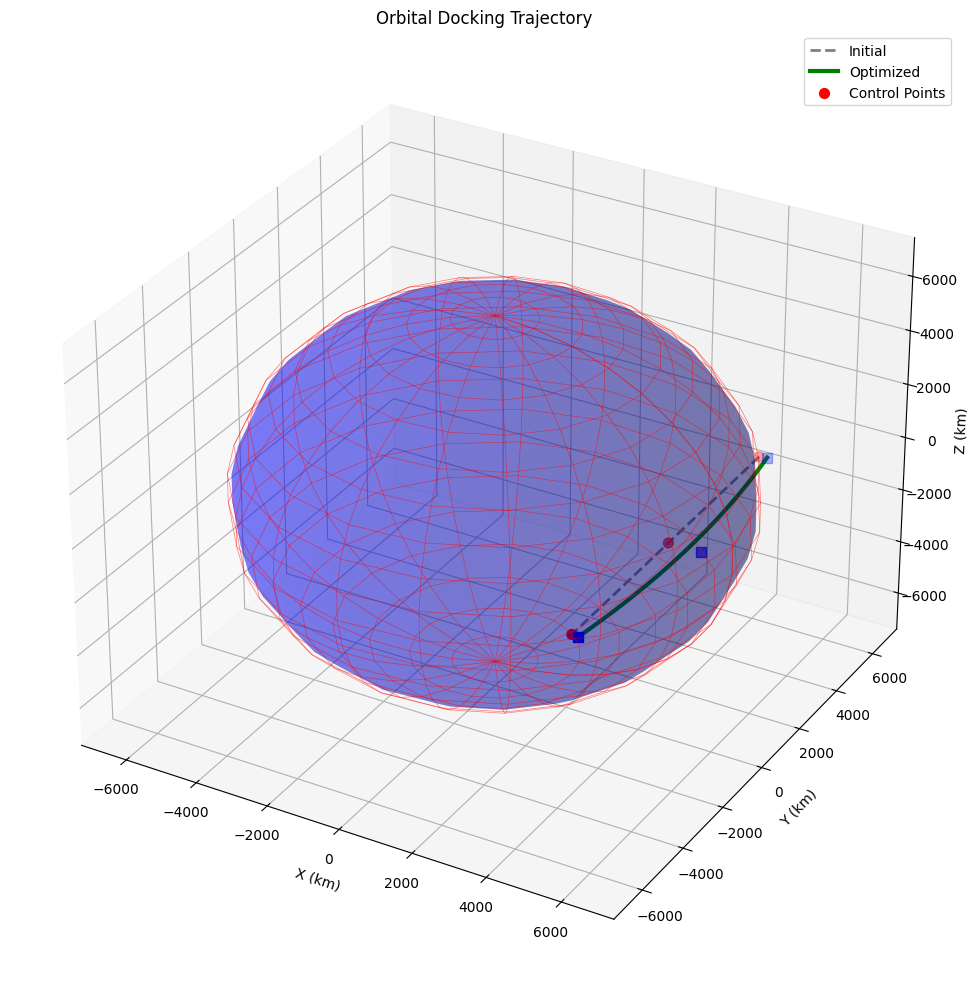

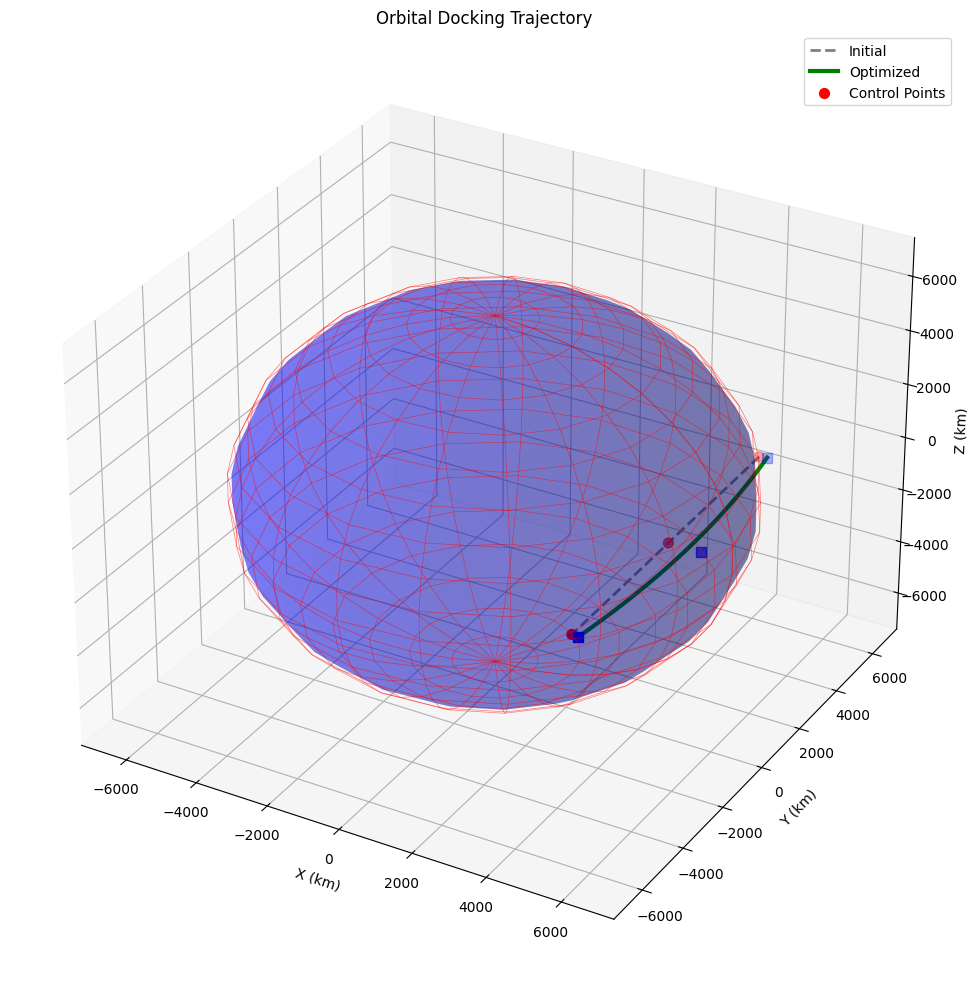

In [52]:
plot_trajectory_3d(P_init, P_opt, KOZ_RADIUS)
# plot_profiles(P_opt)